# Tutorial - Implementing a custom analysis block in Lightwood


## Introduction

As you might already know, Lightwood is designed to be a flexible machine learning (ML) library that is able to abstract and automate the entire ML pipeline. Crucially, it is also designed to be extended or modified very easily according to your needs, essentially offering the entire spectrum between fully automated AutoML and a lightweight wrapper for customized ML pipelines.

As such, we can identify several different customizable "phases" in the process. The relevant phase for this tutorial is the "analysis" that comes after a predictor has been trained. The goal of this phase is to generate useful insights, like accuracy metrics, confusion matrices, feature importance, etc. These particular examples are all included in the core analysis procedure that Lightwood executes.

However, the analysis procedure is structured into a sequential execution of "analysis blocks". Each analysis block should generate a well-defined set of insights, as well as handling any actions regarding these at inference time.

As an example, one of the core blocks is the Inductive Conformal Prediction (`ICP`) block, which handles the confidence estimation of all Lightwood predictors. The logic within can be complex at times, but thanks to the block abstraction we can deal with it in a structured manner. As this `ICP` block is used when generating predictions, it implements the two main methods that the `BaseAnalysisBlock` class specifies: `.analyze()` to setup everything that is needed, and `.explain()` to actually estimate the confidence in any given prediction.


## Objective

In this tutorial, we will go through the steps required to implement your own analysis blocks to customize the insights of any Lightwood predictor!

In particular, we will implement a "model correlation heatmap" block: we want to compare the predictions of all mixers inside a `BestOf` ensemble object, to understand how they might differ in their overall behavior.

In [1]:
from typing import Dict, Tuple
import pandas as pd
import lightwood
lightwood.__version__

INFO:lightwood-2691:No torchvision detected, image helpers not supported.


INFO:lightwood-2691:No torchvision/pillow detected, image encoder not supported


'24.5.2.0'

## Step 1: figuring out what we need

When designing an analysis block, an important choice needs to be made: will this block operate when calling the predictor? Or is it only going to describe its performance once in the held-out validation dataset?

Being in the former case means we need to implement both `.analyze()` and `.explain()` methods, while the latter case only needs an `.analyze()` method. Our `ModelCorrelationHeatmap` belongs to this second category.

Let's start the implementation by inheriting from `BaseAnalysisBlock`:

In [2]:
from lightwood.analysis import BaseAnalysisBlock

class ModelCorrelationHeatmap(BaseAnalysisBlock):
    def __init__(self, deps=tuple()):
        super().__init__(deps=deps)
        
    def analyze(self, info: Dict[str, object], **kwargs) -> Dict[str, object]:
        return info

    def explain(self,
                row_insights: pd.DataFrame,
                global_insights: Dict[str, object], **kwargs) -> Tuple[pd.DataFrame, Dict[str, object]]:
        
        return row_insights, global_insights

In [3]:
ModelCorrelationHeatmap()

Right now, our newly created analysis block doesn't do much, apart from returning the `info` and insights (`row_insights` and `global_insights`) exactly as it received them from the previous block.

As previously discussed, we only need to implement a procedure that runs post-training, no action is required at inference time. This means we can use the default `.explain()` behavior in the parent class:

In [4]:
class ModelCorrelationHeatmap(BaseAnalysisBlock):
    def __init__(self, deps=tuple()):
        super().__init__(deps=deps)
        
    def analyze(self, info: Dict[str, object], **kwargs) -> Dict[str, object]:
        return info

## Step 2: Implementing the custom analysis block

Okay, now for the fun bit: we have to implement a correlation heatmap between the predictions of all mixers inside a `BestOf` ensemble. This is currently the only ensemble implemented in Lightwood, but it is a good idea to explicitly check that the type of the ensemble is what we expect.

A natural question to ask at this point is: what information do we have to implement the procedure? You'll note that, apart from the `info` dictionary, we receive a `kwargs` dictionary. You can check out the full documentation for more details, but the keys (and respective value types) exposed in this object by default are:

In [5]:
kwargs = {
        'predictor': 'lightwood.ensemble.BaseEnsemble',
        'target': 'str',
        'input_cols': 'list',
        'dtype_dict': 'dict',
        'normal_predictions': 'pd.DataFrame',
        'data': 'pd.DataFrame',
        'train_data': 'lightwood.data.encoded_ds.EncodedDs',
        'encoded_val_data': 'lightwood.data.encoded_ds.EncodedDs',
        'is_classification': 'bool',
        'is_numerical': 'bool',
        'is_multi_ts': 'bool',
        'stats_info': 'lightwood.api.types.StatisticalAnalysis',
        'ts_cfg': 'lightwood.api.types.TimeseriesSettings',
        'accuracy_functions': 'list',
        'has_pretrained_text_enc': 'bool'
}

As you can see there is lots to work with, but for this example we will focus on using:

1. The `predictor` ensemble
2. The `encoded_val_data` to generate predictions for each mixer inside the ensemble

And the insight we're want to produce is a matrix that compares the output of all mixers and computes the correlation between them.

Let's implement the algorithm:

In [6]:
%%writefile model_correlation.py

from typing import Dict
from types import SimpleNamespace

import numpy as np

from lightwood.ensemble import BestOf
from lightwood.analysis import BaseAnalysisBlock


class ModelCorrelationHeatmap(BaseAnalysisBlock):
    def __init__(self, deps=tuple()):
        super().__init__(deps=deps)
        
    def analyze(self, info: Dict[str, object], **kwargs) -> Dict[str, object]:
        ns = SimpleNamespace(**kwargs)
        
        # only triggered with the right type of ensemble
        if isinstance(ns.predictor, BestOf):
            
            # store prediction from every mixer
            all_predictions = []

            for mixer in ns.predictor.mixers:
                predictions = mixer(ns.encoded_val_data)['prediction'].values  # retrieve np.ndarray from the returned pd.DataFrame
                all_predictions.append(predictions.flatten().astype(int))  # flatten and cast labels to int

            # calculate correlation matrix
            corrs = np.corrcoef(np.array(all_predictions))
            
            # save inside `info` object
            info['mixer_correlation'] = corrs
        
        return info


Writing model_correlation.py


Notice the use of `SimpleNamespace` for dot notation accessors.

The procedure above is fairly straightforward, as we leverage numpy's `corrcoef()` function to generate the matrix. 

Finally, it is very important to add the output to `info` so that it is saved inside the actual predictor object. 

## Step 3: Exposing the block to Lightwood


To use this in an arbitrary script, we need to add the above class (and all necessary imports) to a `.py` file inside one of the following directories:

* `~/lightwood_modules` (where `~` is your home directory, e.g. `/Users/username/` for macOS and `/home/username/` for linux
* `/etc/lightwood_modules`

Lightwood will scan these directories and import any class so that they can be found and used by the `JsonAI` code generating module.

**To continue, please save the code cell above as `model_correlation.py` in one of the indicated directories.**

## Step 4: Final test run

Ok! Everything looks set to try out our custom block. Let's generate a predictor for [this](https://github.com/mindsdb/lightwood/blob/stable/tests/data/hdi.csv) sample dataset, and see whether our new insights are any good.

First, it is important to add our `ModelCorrelationHeatmap` to the `analysis_blocks` attribute of the Json AI object that will generate your predictor code. 

In [7]:
from lightwood.api.high_level import ProblemDefinition, json_ai_from_problem, load_custom_module

# First, load the custom module we wrote
load_custom_module('model_correlation.py')

# read dataset
df = pd.read_csv('https://raw.githubusercontent.com/mindsdb/lightwood/stable/tests/data/hdi.csv')

# define the predictive task
pdef = ProblemDefinition.from_dict({
    'target': 'Development Index',         # column you want to predict
    'time_aim': 100,
})

# generate the Json AI intermediate representation from the data and its corresponding settings
json_ai = json_ai_from_problem(df, problem_definition=pdef)

# add the custom list of analysis blocks; in this case, composed of a single block
json_ai.analysis_blocks = [{
    'module': 'model_correlation.ModelCorrelationHeatmap',
    'args': {}
}]

INFO:type_infer-2691:Analyzing a sample of 222


INFO:type_infer-2691:from a total population of 225, this is equivalent to 98.7% of your data.


INFO:type_infer-2691:Infering type for: Population


INFO:type_infer-2691:Column Population has data type integer


INFO:type_infer-2691:Infering type for: Area (sq. mi.)


INFO:type_infer-2691:Column Area (sq. mi.) has data type integer


INFO:type_infer-2691:Infering type for: Pop. Density 


INFO:type_infer-2691:Column Pop. Density  has data type float


INFO:type_infer-2691:Infering type for: GDP ($ per capita)


INFO:type_infer-2691:Column GDP ($ per capita) has data type integer


INFO:type_infer-2691:Infering type for: Literacy (%)


INFO:type_infer-2691:Column Literacy (%) has data type float


INFO:type_infer-2691:Infering type for: Infant mortality 


INFO:type_infer-2691:Column Infant mortality  has data type float


INFO:type_infer-2691:Infering type for: Development Index


INFO:type_infer-2691:Column Development Index has data type categorical


INFO:dataprep_ml-2691:Starting statistical analysis


INFO:dataprep_ml-2691:Finished statistical analysis


We can take a look at the respective Json AI key just to confirm our newly added analysis block is in there:

In [8]:
json_ai.analysis_blocks

[{'module': 'model_correlation.ModelCorrelationHeatmap', 'args': {}}]

Now we are ready to create a predictor from this Json AI, and subsequently train it:

In [9]:
from lightwood.api.high_level import code_from_json_ai, predictor_from_code

code = code_from_json_ai(json_ai)
predictor = predictor_from_code(code)

predictor.learn(df)

INFO:dataprep_ml-2691:[Learn phase 1/8] - Statistical analysis


INFO:dataprep_ml-2691:Starting statistical analysis


INFO:dataprep_ml-2691:Finished statistical analysis


DEBUG:lightwood-2691: `analyze_data` runtime: 0.02 seconds


INFO:dataprep_ml-2691:[Learn phase 2/8] - Data preprocessing


INFO:dataprep_ml-2691:Cleaning the data


DEBUG:lightwood-2691: `preprocess` runtime: 0.01 seconds


INFO:dataprep_ml-2691:[Learn phase 3/8] - Data splitting


INFO:dataprep_ml-2691:Splitting the data into train/test


DEBUG:lightwood-2691: `split` runtime: 0.01 seconds


INFO:dataprep_ml-2691:[Learn phase 4/8] - Preparing encoders


DEBUG:dataprep_ml-2691:Preparing sequentially...


DEBUG:dataprep_ml-2691:Preparing encoder for Population...


DEBUG:dataprep_ml-2691:Preparing encoder for Area (sq. mi.)...


DEBUG:dataprep_ml-2691:Preparing encoder for Pop. Density ...


DEBUG:dataprep_ml-2691:Preparing encoder for GDP ($ per capita)...


DEBUG:dataprep_ml-2691:Preparing encoder for Literacy (%)...


DEBUG:dataprep_ml-2691:Preparing encoder for Infant mortality ...


DEBUG:lightwood-2691:Encoding UNKNOWN categories as index 0


DEBUG:lightwood-2691: `prepare` runtime: 0.01 seconds


INFO:dataprep_ml-2691:[Learn phase 5/8] - Feature generation


INFO:dataprep_ml-2691:Featurizing the data


DEBUG:lightwood-2691: `featurize` runtime: 0.05 seconds


INFO:dataprep_ml-2691:[Learn phase 6/8] - Mixer training


INFO:dataprep_ml-2691:Training the mixers


/home/runner/work/lightwood/lightwood/lightwood/mixer/neural.py:124: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/opt/hostedtoolcache/Python/3.9.20/x64/lib/python3.9/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/opt/hostedtoolcache/Python/3.9.20/x64/lib/python3.9/site-packages/pytorch_ranger/ranger.py:172: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value = 1) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1642.)
  exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
INFO:lightwood-2691:Loss of 18.69619858264923 with learning rate 0.0001


INFO:lightwood-2691:Loss of 16.93891429901123 with learning rate 0.0005


INFO:lightwood-2691:Loss of 16.197376608848572 with learning rate 0.001


INFO:lightwood-2691:Loss of 16.06481909751892 with learning rate 0.002


INFO:lightwood-2691:Loss of 16.472004413604736 with learning rate 0.003


INFO:lightwood-2691:Loss of 18.28026556968689 with learning rate 0.005


INFO:lightwood-2691:Loss of 26.746760368347168 with learning rate 0.01


INFO:lightwood-2691:Loss of 101.83524441719055 with learning rate 0.05


INFO:lightwood-2691:Found learning rate of: 0.002


/home/runner/work/lightwood/lightwood/lightwood/mixer/neural.py:305: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
INFO:lightwood-2691:Loss @ epoch 1: 1.319209337234497


INFO:lightwood-2691:Loss @ epoch 2: 1.3220206499099731


INFO:lightwood-2691:Loss @ epoch 3: 1.3063435554504395


INFO:lightwood-2691:Loss @ epoch 4: 1.2932535409927368


INFO:lightwood-2691:Loss @ epoch 5: 1.2823516130447388


INFO:lightwood-2691:Loss @ epoch 6: 1.2705544233322144


INFO:lightwood-2691:Loss @ epoch 7: 1.2418551445007324


INFO:lightwood-2691:Loss @ epoch 8: 1.2208324670791626


INFO:lightwood-2691:Loss @ epoch 9: 1.197828769683838


INFO:lightwood-2691:Loss @ epoch 10: 1.1781431436538696


INFO:lightwood-2691:Loss @ epoch 11: 1.161504864692688


INFO:lightwood-2691:Loss @ epoch 12: 1.1442031860351562


INFO:lightwood-2691:Loss @ epoch 13: 1.1058541536331177


INFO:lightwood-2691:Loss @ epoch 14: 1.0935649871826172


[10:40:29] WARNING: ../src/learner.cc:339: No visible GPU is found, setting `gpu_id` to -1


INFO:lightwood-2691:Loss @ epoch 15: 1.0802721977233887


INFO:lightwood-2691:Loss @ epoch 16: 1.0696258544921875


INFO:lightwood-2691:Loss @ epoch 17: 1.0607414245605469


INFO:lightwood-2691:Loss @ epoch 18: 1.0493905544281006


INFO:lightwood-2691:Loss @ epoch 19: 1.020617961883545


INFO:lightwood-2691:Loss @ epoch 20: 1.0081787109375


INFO:lightwood-2691:Loss @ epoch 21: 0.9943330883979797


INFO:lightwood-2691:Loss @ epoch 22: 0.9842473268508911


INFO:lightwood-2691:Loss @ epoch 23: 0.9762145280838013


INFO:lightwood-2691:Loss @ epoch 24: 0.9653865098953247


INFO:lightwood-2691:Loss @ epoch 25: 0.9380742311477661


INFO:lightwood-2691:Loss @ epoch 26: 0.9271669387817383


INFO:lightwood-2691:Loss @ epoch 27: 0.9147073030471802


INFO:lightwood-2691:Loss @ epoch 28: 0.9064992070198059


INFO:lightwood-2691:Loss @ epoch 29: 0.900122344493866


INFO:lightwood-2691:Loss @ epoch 30: 0.8903173208236694


INFO:lightwood-2691:Loss @ epoch 31: 0.8648637533187866


INFO:lightwood-2691:Loss @ epoch 32: 0.8549227118492126


INFO:lightwood-2691:Loss @ epoch 33: 0.8434366583824158


INFO:lightwood-2691:Loss @ epoch 34: 0.8365358114242554


INFO:lightwood-2691:Loss @ epoch 35: 0.831310510635376


INFO:lightwood-2691:Loss @ epoch 36: 0.8222441673278809


INFO:lightwood-2691:Loss @ epoch 37: 0.7981722950935364


INFO:lightwood-2691:Loss @ epoch 38: 0.789170503616333


INFO:lightwood-2691:Loss @ epoch 39: 0.7787192463874817


INFO:lightwood-2691:Loss @ epoch 40: 0.7730110287666321


INFO:lightwood-2691:Loss @ epoch 41: 0.7687097787857056


INFO:lightwood-2691:Loss @ epoch 42: 0.7602015137672424


INFO:lightwood-2691:Loss @ epoch 43: 0.7373268604278564


INFO:lightwood-2691:Loss @ epoch 44: 0.7292225956916809


INFO:lightwood-2691:Loss @ epoch 45: 0.7197889685630798


INFO:lightwood-2691:Loss @ epoch 46: 0.7151773571968079


INFO:lightwood-2691:Loss @ epoch 47: 0.7117206454277039


INFO:lightwood-2691:Loss @ epoch 48: 0.7038285136222839


INFO:lightwood-2691:Loss @ epoch 49: 0.682073175907135


INFO:lightwood-2691:Loss @ epoch 50: 0.674643874168396


INFO:lightwood-2691:Loss @ epoch 51: 0.6659626364707947


INFO:lightwood-2691:Loss @ epoch 52: 0.6620772480964661


INFO:lightwood-2691:Loss @ epoch 53: 0.6590715646743774


INFO:lightwood-2691:Loss @ epoch 54: 0.6515910625457764


INFO:lightwood-2691:Loss @ epoch 55: 0.6308077573776245


INFO:lightwood-2691:Loss @ epoch 56: 0.6241987347602844


INFO:lightwood-2691:Loss @ epoch 57: 0.6163835525512695


INFO:lightwood-2691:Loss @ epoch 58: 0.6131908297538757


INFO:lightwood-2691:Loss @ epoch 59: 0.6106155514717102


INFO:lightwood-2691:Loss @ epoch 60: 0.6036757826805115


INFO:lightwood-2691:Loss @ epoch 61: 0.5848420262336731


INFO:lightwood-2691:Loss @ epoch 62: 0.5793871879577637


INFO:lightwood-2691:Loss @ epoch 63: 0.5726662278175354


INFO:lightwood-2691:Loss @ epoch 64: 0.5703645348548889


INFO:lightwood-2691:Loss @ epoch 65: 0.5684641003608704


INFO:lightwood-2691:Loss @ epoch 66: 0.5622180104255676


INFO:lightwood-2691:Loss @ epoch 67: 0.5449516773223877


INFO:lightwood-2691:Loss @ epoch 68: 0.5401747226715088


INFO:lightwood-2691:Loss @ epoch 69: 0.5341063141822815


INFO:lightwood-2691:Loss @ epoch 70: 0.5322306752204895


INFO:lightwood-2691:Loss @ epoch 71: 0.5305425524711609


INFO:lightwood-2691:Loss @ epoch 72: 0.5246548056602478


INFO:lightwood-2691:Loss @ epoch 73: 0.5083626508712769


INFO:lightwood-2691:Loss @ epoch 74: 0.5040708184242249


INFO:lightwood-2691:Loss @ epoch 75: 0.49863335490226746


INFO:lightwood-2691:Loss @ epoch 76: 0.49717265367507935


INFO:lightwood-2691:Loss @ epoch 77: 0.49564701318740845


INFO:lightwood-2691:Loss @ epoch 78: 0.4900944232940674


INFO:lightwood-2691:Loss @ epoch 79: 0.47473227977752686


INFO:lightwood-2691:Loss @ epoch 80: 0.4708785116672516


INFO:lightwood-2691:Loss @ epoch 81: 0.46578508615493774


INFO:lightwood-2691:Loss @ epoch 82: 0.4644494950771332


INFO:lightwood-2691:Loss @ epoch 83: 0.4629424810409546


INFO:lightwood-2691:Loss @ epoch 84: 0.4576236307621002


INFO:lightwood-2691:Loss @ epoch 85: 0.44295966625213623


INFO:lightwood-2691:Loss @ epoch 86: 0.4393518269062042


INFO:lightwood-2691:Loss @ epoch 87: 0.4346559941768646


INFO:lightwood-2691:Loss @ epoch 88: 0.43358123302459717


INFO:lightwood-2691:Loss @ epoch 89: 0.43231165409088135


INFO:lightwood-2691:Loss @ epoch 90: 0.42753666639328003


INFO:lightwood-2691:Loss @ epoch 91: 0.41425880789756775


INFO:lightwood-2691:Loss @ epoch 92: 0.4113253951072693


INFO:lightwood-2691:Loss @ epoch 93: 0.4074642062187195


INFO:lightwood-2691:Loss @ epoch 94: 0.40698081254959106


INFO:lightwood-2691:Loss @ epoch 95: 0.4062195420265198


INFO:lightwood-2691:Loss @ epoch 96: 0.4020974636077881


INFO:lightwood-2691:Loss @ epoch 97: 0.3904534876346588


INFO:lightwood-2691:Loss @ epoch 98: 0.3879585564136505


INFO:lightwood-2691:Loss @ epoch 99: 0.38447296619415283


INFO:lightwood-2691:Loss @ epoch 100: 0.3841344118118286


INFO:lightwood-2691:Loss @ epoch 101: 0.3833732604980469


INFO:lightwood-2691:Loss @ epoch 102: 0.37956172227859497


INFO:lightwood-2691:Loss @ epoch 103: 0.36883822083473206


INFO:lightwood-2691:Loss @ epoch 104: 0.3664571940898895


INFO:lightwood-2691:Loss @ epoch 105: 0.36335548758506775


INFO:lightwood-2691:Loss @ epoch 106: 0.36316758394241333


INFO:lightwood-2691:Loss @ epoch 107: 0.3625164330005646


INFO:lightwood-2691:Loss @ epoch 108: 0.359012246131897


INFO:lightwood-2691:Loss @ epoch 109: 0.34912365674972534


INFO:lightwood-2691:Loss @ epoch 110: 0.34696850180625916


INFO:lightwood-2691:Loss @ epoch 111: 0.3441202938556671


INFO:lightwood-2691:Loss @ epoch 112: 0.34398093819618225


INFO:lightwood-2691:Loss @ epoch 113: 0.3432472050189972


INFO:lightwood-2691:Loss @ epoch 114: 0.3399496376514435


INFO:lightwood-2691:Loss @ epoch 115: 0.3308461308479309


INFO:lightwood-2691:Loss @ epoch 116: 0.3289041221141815


INFO:lightwood-2691:Loss @ epoch 117: 0.32627207040786743


INFO:lightwood-2691:Loss @ epoch 118: 0.3261372447013855


INFO:lightwood-2691:Loss @ epoch 119: 0.32546231150627136


INFO:lightwood-2691:Loss @ epoch 120: 0.3224080502986908


INFO:lightwood-2691:Loss @ epoch 121: 0.314008891582489


INFO:lightwood-2691:Loss @ epoch 122: 0.31220486760139465


INFO:lightwood-2691:Loss @ epoch 123: 0.3098214566707611


INFO:lightwood-2691:Loss @ epoch 124: 0.30979809165000916


INFO:lightwood-2691:Loss @ epoch 125: 0.3090403079986572


INFO:lightwood-2691:Loss @ epoch 126: 0.30612480640411377


INFO:lightwood-2691:Loss @ epoch 127: 0.29819032549858093


INFO:lightwood-2691:Loss @ epoch 128: 0.29648637771606445


INFO:lightwood-2691:Loss @ epoch 129: 0.2943042516708374


INFO:lightwood-2691:Loss @ epoch 130: 0.29420480132102966


INFO:lightwood-2691:Loss @ epoch 131: 0.2934538424015045


INFO:lightwood-2691:Loss @ epoch 132: 0.2907505929470062


INFO:lightwood-2691:Loss @ epoch 133: 0.2835786044597626


INFO:lightwood-2691:Loss @ epoch 134: 0.28203263878822327


INFO:lightwood-2691:Loss @ epoch 135: 0.2801313102245331


INFO:lightwood-2691:Loss @ epoch 136: 0.2801584303379059


INFO:lightwood-2691:Loss @ epoch 137: 0.27946653962135315


INFO:lightwood-2691:Loss @ epoch 138: 0.2770102620124817


INFO:lightwood-2691:Loss @ epoch 139: 0.2705138921737671


INFO:lightwood-2691:Loss @ epoch 140: 0.2689667046070099


INFO:lightwood-2691:Loss @ epoch 141: 0.26713839173316956


INFO:lightwood-2691:Loss @ epoch 142: 0.26722976565361023


INFO:lightwood-2691:Loss @ epoch 143: 0.26659274101257324


INFO:lightwood-2691:Loss @ epoch 144: 0.26436734199523926


INFO:lightwood-2691:Loss @ epoch 145: 0.2585783302783966


INFO:lightwood-2691:Loss @ epoch 146: 0.25718021392822266


INFO:lightwood-2691:Loss @ epoch 147: 0.25569674372673035


INFO:lightwood-2691:Loss @ epoch 148: 0.25572293996810913


INFO:lightwood-2691:Loss @ epoch 149: 0.254925012588501


INFO:lightwood-2691:Loss @ epoch 150: 0.25273722410202026


INFO:lightwood-2691:Loss @ epoch 151: 0.24740025401115417


INFO:lightwood-2691:Loss @ epoch 152: 0.24594709277153015


INFO:lightwood-2691:Loss @ epoch 153: 0.2445458471775055


INFO:lightwood-2691:Loss @ epoch 154: 0.2445453554391861


INFO:lightwood-2691:Loss @ epoch 155: 0.24368290603160858


INFO:lightwood-2691:Loss @ epoch 156: 0.2416052669286728


INFO:lightwood-2691:Loss @ epoch 157: 0.23683445155620575


INFO:lightwood-2691:Loss @ epoch 158: 0.23561015725135803


INFO:lightwood-2691:Loss @ epoch 159: 0.2342897355556488


INFO:lightwood-2691:Loss @ epoch 160: 0.2342986762523651


INFO:lightwood-2691:Loss @ epoch 161: 0.2334001511335373


INFO:lightwood-2691:Loss @ epoch 162: 0.23141320049762726


INFO:lightwood-2691:Loss @ epoch 163: 0.22705355286598206


INFO:lightwood-2691:Loss @ epoch 164: 0.22583813965320587


INFO:lightwood-2691:Loss @ epoch 165: 0.22455710172653198


INFO:lightwood-2691:Loss @ epoch 166: 0.2245052307844162


INFO:lightwood-2691:Loss @ epoch 167: 0.22359803318977356


INFO:lightwood-2691:Loss @ epoch 168: 0.22173909842967987


INFO:lightwood-2691:Loss @ epoch 169: 0.2178291231393814


INFO:lightwood-2691:Loss @ epoch 170: 0.21670299768447876


INFO:lightwood-2691:Loss @ epoch 171: 0.21559178829193115


INFO:lightwood-2691:Loss @ epoch 172: 0.21557293832302094


INFO:lightwood-2691:Loss @ epoch 173: 0.21463343501091003


INFO:lightwood-2691:Loss @ epoch 174: 0.21291333436965942


INFO:lightwood-2691:Loss @ epoch 175: 0.20953477919101715


INFO:lightwood-2691:Loss @ epoch 176: 0.20840951800346375


INFO:lightwood-2691:Loss @ epoch 177: 0.20733794569969177


INFO:lightwood-2691:Loss @ epoch 178: 0.20730628073215485


INFO:lightwood-2691:Loss @ epoch 179: 0.20635393261909485


INFO:lightwood-2691:Loss @ epoch 180: 0.20470596849918365


INFO:lightwood-2691:Loss @ epoch 181: 0.2016059160232544


INFO:lightwood-2691:Loss @ epoch 182: 0.2004680186510086


INFO:lightwood-2691:Loss @ epoch 183: 0.1995442509651184


INFO:lightwood-2691:Loss @ epoch 184: 0.1995476931333542


INFO:lightwood-2691:Loss @ epoch 185: 0.1985597461462021


INFO:lightwood-2691:Loss @ epoch 186: 0.19704405963420868


INFO:lightwood-2691:Loss @ epoch 187: 0.19429439306259155


INFO:lightwood-2691:Loss @ epoch 188: 0.1931215077638626


INFO:lightwood-2691:Loss @ epoch 189: 0.19224728643894196


INFO:lightwood-2691:Loss @ epoch 190: 0.1922168731689453


INFO:lightwood-2691:Loss @ epoch 191: 0.19120150804519653


INFO:lightwood-2691:Loss @ epoch 192: 0.1897118091583252


INFO:lightwood-2691:Loss @ epoch 193: 0.187192901968956


INFO:lightwood-2691:Loss @ epoch 194: 0.18604235351085663


INFO:lightwood-2691:Loss @ epoch 195: 0.18525990843772888


INFO:lightwood-2691:Loss @ epoch 196: 0.18517257273197174


INFO:lightwood-2691:Loss @ epoch 197: 0.1841844767332077


INFO:lightwood-2691:Loss @ epoch 198: 0.18275843560695648


INFO:lightwood-2691:Loss @ epoch 199: 0.18052375316619873


INFO:lightwood-2691:Loss @ epoch 200: 0.1795222908258438


INFO:lightwood-2691:Loss @ epoch 201: 0.17878693342208862


INFO:lightwood-2691:Loss @ epoch 202: 0.17881926894187927


INFO:lightwood-2691:Loss @ epoch 203: 0.17786364257335663


INFO:lightwood-2691:Loss @ epoch 204: 0.17654098570346832


INFO:lightwood-2691:Loss @ epoch 205: 0.17458021640777588


INFO:lightwood-2691:Loss @ epoch 206: 0.17358489334583282


INFO:lightwood-2691:Loss @ epoch 207: 0.1728101521730423


INFO:lightwood-2691:Loss @ epoch 208: 0.17278429865837097


INFO:lightwood-2691:Loss @ epoch 209: 0.17180292308330536


INFO:lightwood-2691:Loss @ epoch 210: 0.17050613462924957


INFO:lightwood-2691:Loss @ epoch 211: 0.16873842477798462


INFO:lightwood-2691:Loss @ epoch 212: 0.1677248477935791


INFO:lightwood-2691:Loss @ epoch 213: 0.16707710921764374


INFO:lightwood-2691:Loss @ epoch 214: 0.1671123504638672


INFO:lightwood-2691:Loss @ epoch 215: 0.16612616181373596


INFO:lightwood-2691:Loss @ epoch 216: 0.16487975418567657


INFO:lightwood-2691:Loss @ epoch 217: 0.16339382529258728


INFO:lightwood-2691:Loss @ epoch 218: 0.1624278575181961


INFO:lightwood-2691:Loss @ epoch 219: 0.16172048449516296


INFO:lightwood-2691:Loss @ epoch 220: 0.16165515780448914


INFO:lightwood-2691:Loss @ epoch 221: 0.16061937808990479


INFO:lightwood-2691:Loss @ epoch 222: 0.1594206690788269


INFO:lightwood-2691:Loss @ epoch 223: 0.15802235901355743


INFO:lightwood-2691:Loss @ epoch 224: 0.15704363584518433


INFO:lightwood-2691:Loss @ epoch 225: 0.15640243887901306


INFO:lightwood-2691:Loss @ epoch 226: 0.15635541081428528


INFO:lightwood-2691:Loss @ epoch 227: 0.15536457300186157


INFO:lightwood-2691:Loss @ epoch 228: 0.154209703207016


INFO:lightwood-2691:Loss @ epoch 229: 0.15291643142700195


INFO:lightwood-2691:Loss @ epoch 230: 0.15191468596458435


INFO:lightwood-2691:Loss @ epoch 231: 0.15118129551410675


INFO:lightwood-2691:Loss @ epoch 232: 0.151133194565773


INFO:lightwood-2691:Loss @ epoch 233: 0.1501670926809311


INFO:lightwood-2691:Loss @ epoch 234: 0.14912192523479462


INFO:lightwood-2691:Loss @ epoch 235: 0.1481197327375412


INFO:lightwood-2691:Loss @ epoch 236: 0.14712536334991455


INFO:lightwood-2691:Loss @ epoch 237: 0.14660944044589996


INFO:lightwood-2691:Loss @ epoch 238: 0.14649781584739685


INFO:lightwood-2691:Loss @ epoch 239: 0.145524799823761


INFO:lightwood-2691:Loss @ epoch 240: 0.14443959295749664


INFO:lightwood-2691:Loss @ epoch 241: 0.14341002702713013


INFO:lightwood-2691:Loss @ epoch 242: 0.14249812066555023


INFO:lightwood-2691:Loss @ epoch 243: 0.14185366034507751


INFO:lightwood-2691:Loss @ epoch 244: 0.1419423222541809


INFO:lightwood-2691:Loss @ epoch 245: 0.1409326195716858


INFO:lightwood-2691:Loss @ epoch 246: 0.1399424970149994


INFO:lightwood-2691:Loss @ epoch 247: 0.13920661807060242


INFO:lightwood-2691:Loss @ epoch 248: 0.13832959532737732


INFO:lightwood-2691:Loss @ epoch 249: 0.13784818351268768


INFO:lightwood-2691:Loss @ epoch 250: 0.13769637048244476


INFO:lightwood-2691:Loss @ epoch 251: 0.1367887407541275


INFO:lightwood-2691:Loss @ epoch 252: 0.13588252663612366


INFO:lightwood-2691:Loss @ epoch 253: 0.13521170616149902


INFO:lightwood-2691:Loss @ epoch 254: 0.13428467512130737


INFO:lightwood-2691:Loss @ epoch 255: 0.13384407758712769


INFO:lightwood-2691:Loss @ epoch 256: 0.13372991979122162


INFO:lightwood-2691:Loss @ epoch 257: 0.13274942338466644


INFO:lightwood-2691:Loss @ epoch 258: 0.13186557590961456


INFO:lightwood-2691:Loss @ epoch 259: 0.13135230541229248


INFO:lightwood-2691:Loss @ epoch 260: 0.13046588003635406


INFO:lightwood-2691:Loss @ epoch 261: 0.12980172038078308


INFO:lightwood-2691:Loss @ epoch 262: 0.12982229888439178


INFO:lightwood-2691:Loss @ epoch 263: 0.12882845103740692


INFO:lightwood-2691:Loss @ epoch 264: 0.12798714637756348


INFO:lightwood-2691:Loss @ epoch 265: 0.12758088111877441


INFO:lightwood-2691:Loss @ epoch 266: 0.12660843133926392


INFO:lightwood-2691:Loss @ epoch 267: 0.1261577606201172


INFO:lightwood-2691:Loss @ epoch 268: 0.1260918229818344


INFO:lightwood-2691:Loss @ epoch 269: 0.12515920400619507


INFO:lightwood-2691:Loss @ epoch 270: 0.12436933070421219


INFO:lightwood-2691:Loss @ epoch 271: 0.12405422329902649


INFO:lightwood-2691:Loss @ epoch 272: 0.12305409461259842


INFO:lightwood-2691:Loss @ epoch 273: 0.12272939085960388


INFO:lightwood-2691:Loss @ epoch 274: 0.12267134338617325


INFO:lightwood-2691:Loss @ epoch 275: 0.12182944267988205


INFO:lightwood-2691:Loss @ epoch 276: 0.12103450298309326


INFO:lightwood-2691:Loss @ epoch 277: 0.12083345651626587


INFO:lightwood-2691:Loss @ epoch 278: 0.11998103559017181


INFO:lightwood-2691:Loss @ epoch 279: 0.11937755346298218


INFO:lightwood-2691:Loss @ epoch 280: 0.1195112019777298


INFO:lightwood-2691:Loss @ epoch 281: 0.1185888797044754


INFO:lightwood-2691:Loss @ epoch 282: 0.11789504438638687


INFO:lightwood-2691:Loss @ epoch 283: 0.11783000081777573


INFO:lightwood-2691:Loss @ epoch 284: 0.11681754887104034


INFO:lightwood-2691:Loss @ epoch 285: 0.11649196594953537


INFO:lightwood-2691:Loss @ epoch 286: 0.11648327857255936


INFO:lightwood-2691:Loss @ epoch 287: 0.11562418192625046


INFO:lightwood-2691:Loss @ epoch 288: 0.11489420384168625


INFO:lightwood-2691:Loss @ epoch 289: 0.11485717445611954


INFO:lightwood-2691:Loss @ epoch 290: 0.11407709866762161


INFO:lightwood-2691:Loss @ epoch 291: 0.11348505318164825


INFO:lightwood-2691:Loss @ epoch 292: 0.11358898878097534


INFO:lightwood-2691:Loss @ epoch 293: 0.11268813163042068


INFO:lightwood-2691:Loss @ epoch 294: 0.11207651346921921


INFO:lightwood-2691:Loss @ epoch 295: 0.11220688372850418


INFO:lightwood-2691:Loss @ epoch 296: 0.11118005961179733


INFO:lightwood-2691:Loss @ epoch 297: 0.11089354008436203


INFO:lightwood-2691:Loss @ epoch 298: 0.11088859289884567


INFO:lightwood-2691:Loss @ epoch 299: 0.1100316271185875


INFO:lightwood-2691:Loss @ epoch 300: 0.1093800961971283


INFO:lightwood-2691:Loss @ epoch 301: 0.10955681651830673


INFO:lightwood-2691:Loss @ epoch 302: 0.10869839787483215


INFO:lightwood-2691:Loss @ epoch 303: 0.10815789550542831


INFO:lightwood-2691:Loss @ epoch 304: 0.10832306742668152


INFO:lightwood-2691:Loss @ epoch 305: 0.10742544382810593


INFO:lightwood-2691:Loss @ epoch 306: 0.10682710260152817


INFO:lightwood-2691:Loss @ epoch 307: 0.10698221623897552


INFO:lightwood-2691:Loss @ epoch 308: 0.10616409033536911


INFO:lightwood-2691:Loss @ epoch 309: 0.10568025708198547


INFO:lightwood-2691:Loss @ epoch 310: 0.10574078559875488


INFO:lightwood-2691:Loss @ epoch 311: 0.10493995994329453


INFO:lightwood-2691:Loss @ epoch 312: 0.10438455641269684


INFO:lightwood-2691:Loss @ epoch 313: 0.10449497401714325


INFO:lightwood-2691:Loss @ epoch 314: 0.10372297465801239


INFO:lightwood-2691:Loss @ epoch 315: 0.10320515185594559


INFO:lightwood-2691:Loss @ epoch 316: 0.10330332815647125


INFO:lightwood-2691:Loss @ epoch 317: 0.10239537805318832


INFO:lightwood-2691:Loss @ epoch 318: 0.10185065120458603


INFO:lightwood-2691:Loss @ epoch 319: 0.10217708349227905


INFO:lightwood-2691:Loss @ epoch 320: 0.10135672241449356


INFO:lightwood-2691:Loss @ epoch 321: 0.10087659955024719


INFO:lightwood-2691:Loss @ epoch 322: 0.10087589174509048


INFO:lightwood-2691:Loss @ epoch 323: 0.10005565732717514


INFO:lightwood-2691:Loss @ epoch 324: 0.09949999302625656


INFO:lightwood-2691:Loss @ epoch 325: 0.09970266371965408


INFO:lightwood-2691:Loss @ epoch 326: 0.09918338060379028


INFO:lightwood-2691:Loss @ epoch 327: 0.09840800613164902


INFO:lightwood-2691:Loss @ epoch 328: 0.09882311522960663


INFO:lightwood-2691:Loss @ epoch 329: 0.09775345772504807


INFO:lightwood-2691:Loss @ epoch 330: 0.09729817509651184


INFO:lightwood-2691:Loss @ epoch 331: 0.09763044863939285


INFO:lightwood-2691:Loss @ epoch 332: 0.0967596173286438


INFO:lightwood-2691:Loss @ epoch 333: 0.09642492234706879


INFO:lightwood-2691:Loss @ epoch 334: 0.09656761586666107


INFO:lightwood-2691:Loss @ epoch 335: 0.09573261439800262


INFO:lightwood-2691:Loss @ epoch 336: 0.09523642063140869


INFO:lightwood-2691:Loss @ epoch 337: 0.09568659961223602


INFO:lightwood-2691:Loss @ epoch 338: 0.09509280323982239


INFO:lightwood-2691:Loss @ epoch 339: 0.09460369497537613


INFO:lightwood-2691:Loss @ epoch 340: 0.09476538747549057


INFO:lightwood-2691:Loss @ epoch 341: 0.09388881921768188


INFO:lightwood-2691:Loss @ epoch 342: 0.09349637478590012


INFO:lightwood-2691:Loss @ epoch 343: 0.09398090839385986


INFO:lightwood-2691:Loss @ epoch 344: 0.09314301609992981


INFO:lightwood-2691:Loss @ epoch 345: 0.09281699359416962


INFO:lightwood-2691:Loss @ epoch 346: 0.09290202707052231


INFO:lightwood-2691:Loss @ epoch 347: 0.09209518879652023


INFO:lightwood-2691:Loss @ epoch 348: 0.09171803295612335


INFO:lightwood-2691:Loss @ epoch 349: 0.09221566468477249


INFO:lightwood-2691:Loss @ epoch 350: 0.09150414168834686


INFO:lightwood-2691:Loss @ epoch 351: 0.0910501629114151


INFO:lightwood-2691:Loss @ epoch 352: 0.09118885546922684


INFO:lightwood-2691:Loss @ epoch 353: 0.09043896198272705


INFO:lightwood-2691:Loss @ epoch 354: 0.09006913751363754


INFO:lightwood-2691:Loss @ epoch 355: 0.09049264341592789


INFO:lightwood-2691:Loss @ epoch 356: 0.0898597463965416


INFO:lightwood-2691:Loss @ epoch 357: 0.08943390846252441


INFO:lightwood-2691:Loss @ epoch 358: 0.0896739661693573


INFO:lightwood-2691:Loss @ epoch 359: 0.08882326632738113


INFO:lightwood-2691:Loss @ epoch 360: 0.08850156515836716


INFO:lightwood-2691:Loss @ epoch 361: 0.08897048979997635


INFO:lightwood-2691:Loss @ epoch 362: 0.08849596232175827


INFO:lightwood-2691:Loss @ epoch 363: 0.08790712803602219


INFO:lightwood-2691:Loss @ epoch 364: 0.08821234852075577


INFO:lightwood-2691:Loss @ epoch 365: 0.08732891082763672


INFO:lightwood-2691:Loss @ epoch 366: 0.08704856038093567


INFO:lightwood-2691:Loss @ epoch 367: 0.08765564113855362


INFO:lightwood-2691:Loss @ epoch 368: 0.08696923404932022


INFO:lightwood-2691:Loss @ epoch 369: 0.08649873733520508


INFO:lightwood-2691:Loss @ epoch 370: 0.08676613122224808


INFO:lightwood-2691:Loss @ epoch 371: 0.08599219471216202


INFO:lightwood-2691:Loss @ epoch 372: 0.08565033972263336


INFO:lightwood-2691:Loss @ epoch 373: 0.08618329465389252


INFO:lightwood-2691:Loss @ epoch 374: 0.08559156954288483


INFO:lightwood-2691:Loss @ epoch 375: 0.08509930223226547


INFO:lightwood-2691:Loss @ epoch 376: 0.08543801307678223


INFO:lightwood-2691:Loss @ epoch 377: 0.084554523229599


INFO:lightwood-2691:Loss @ epoch 378: 0.08425222337245941


INFO:lightwood-2691:Loss @ epoch 379: 0.08496475219726562


INFO:lightwood-2691:Loss @ epoch 380: 0.08428442478179932


INFO:lightwood-2691:Loss @ epoch 381: 0.08389458060264587


INFO:lightwood-2691:Loss @ epoch 382: 0.08416417241096497


INFO:lightwood-2691:Loss @ epoch 383: 0.08331726491451263


INFO:lightwood-2691:Loss @ epoch 384: 0.08304726332426071


INFO:lightwood-2691:Loss @ epoch 385: 0.0837259590625763


INFO:lightwood-2691:Loss @ epoch 386: 0.08301664143800735


INFO:lightwood-2691:Loss @ epoch 387: 0.08279375731945038


INFO:lightwood-2691:Loss @ epoch 388: 0.08285657316446304


INFO:lightwood-2691:Loss @ epoch 389: 0.0822003185749054


INFO:lightwood-2691:Loss @ epoch 390: 0.08189017325639725


INFO:lightwood-2691:Loss @ epoch 391: 0.08244460821151733


INFO:lightwood-2691:Loss @ epoch 392: 0.08176209777593613


INFO:lightwood-2691:Loss @ epoch 393: 0.08143384009599686


INFO:lightwood-2691:Loss @ epoch 394: 0.08153267949819565


INFO:lightwood-2691:Loss @ epoch 395: 0.08074252307415009


INFO:lightwood-2691:Loss @ epoch 396: 0.0804641842842102


INFO:lightwood-2691:Loss @ epoch 397: 0.08112648874521255


INFO:lightwood-2691:Loss @ epoch 398: 0.0804068073630333


INFO:lightwood-2691:Loss @ epoch 399: 0.08000007271766663


INFO:lightwood-2691:Loss @ epoch 400: 0.08030638843774796


INFO:lightwood-2691:Loss @ epoch 401: 0.07946185022592545


INFO:lightwood-2691:Loss @ epoch 402: 0.07926557213068008


INFO:lightwood-2691:Loss @ epoch 403: 0.07995376735925674


INFO:lightwood-2691:Loss @ epoch 404: 0.07914069294929504


INFO:lightwood-2691:Loss @ epoch 405: 0.07901032269001007


INFO:lightwood-2691:Loss @ epoch 406: 0.07910943776369095


INFO:lightwood-2691:Loss @ epoch 407: 0.07840055227279663


INFO:lightwood-2691:Loss @ epoch 408: 0.07814037799835205


INFO:lightwood-2691:Loss @ epoch 409: 0.07874786853790283


INFO:lightwood-2691:Loss @ epoch 410: 0.07819069921970367


INFO:lightwood-2691:Loss @ epoch 411: 0.07780887931585312


INFO:lightwood-2691:Loss @ epoch 412: 0.07802116870880127


INFO:lightwood-2691:Loss @ epoch 413: 0.0772867277264595


INFO:lightwood-2691:Loss @ epoch 414: 0.07709880918264389


INFO:lightwood-2691:Loss @ epoch 415: 0.0776868537068367


INFO:lightwood-2691:Loss @ epoch 416: 0.07716330885887146


INFO:lightwood-2691:Loss @ epoch 417: 0.07688125967979431


INFO:lightwood-2691:Loss @ epoch 418: 0.07698465138673782


INFO:lightwood-2691:Loss @ epoch 419: 0.0762372612953186


INFO:lightwood-2691:Loss @ epoch 420: 0.07603802531957626


INFO:lightwood-2691:Loss @ epoch 421: 0.07675285637378693


INFO:lightwood-2691:Loss @ epoch 422: 0.07623977214097977


INFO:lightwood-2691:Loss @ epoch 423: 0.07567108422517776


INFO:lightwood-2691:Loss @ epoch 424: 0.07615751028060913


INFO:lightwood-2691:Loss @ epoch 425: 0.07526733726263046


INFO:lightwood-2691:Loss @ epoch 426: 0.07509555667638779


INFO:lightwood-2691:Loss @ epoch 427: 0.07569493353366852


INFO:lightwood-2691:Loss @ epoch 428: 0.07537294924259186


INFO:lightwood-2691:Loss @ epoch 429: 0.07467805594205856


INFO:lightwood-2691:Loss @ epoch 430: 0.07528648525476456


INFO:lightwood-2691:Loss @ epoch 431: 0.07435967028141022


INFO:lightwood-2691:Loss @ epoch 432: 0.07422596961259842


INFO:lightwood-2691:Loss @ epoch 433: 0.07503972947597504


INFO:lightwood-2691:Loss @ epoch 434: 0.07434249669313431


INFO:lightwood-2691:Loss @ epoch 435: 0.07409335672855377


INFO:lightwood-2691:Loss @ epoch 436: 0.07420685887336731


INFO:lightwood-2691:Loss @ epoch 437: 0.0735834538936615


INFO:lightwood-2691:Loss @ epoch 438: 0.07333341240882874


INFO:lightwood-2691:Loss @ epoch 439: 0.07391082495450974


INFO:lightwood-2691:Loss @ epoch 440: 0.07348911464214325


INFO:lightwood-2691:Loss @ epoch 441: 0.07308389991521835


INFO:lightwood-2691:Loss @ epoch 442: 0.07328886538743973


INFO:lightwood-2691:Loss @ epoch 443: 0.0725550651550293


INFO:lightwood-2691:Loss @ epoch 444: 0.07240220904350281


INFO:lightwood-2691:Loss @ epoch 445: 0.07308465242385864


INFO:lightwood-2691:Loss @ epoch 446: 0.07288312911987305


INFO:lightwood-2691:Loss @ epoch 447: 0.0722663402557373


INFO:lightwood-2691:Loss @ epoch 448: 0.07264856994152069


INFO:lightwood-2691:Loss @ epoch 449: 0.07182618230581284


INFO:lightwood-2691:Loss @ epoch 450: 0.07167533785104752


INFO:lightwood-2691:Loss @ epoch 451: 0.07241341471672058


INFO:lightwood-2691:Loss @ epoch 452: 0.07208056002855301


INFO:lightwood-2691:Loss @ epoch 453: 0.07154601812362671


INFO:lightwood-2691:Loss @ epoch 454: 0.07190731167793274


INFO:lightwood-2691:Loss @ epoch 455: 0.0710812360048294


INFO:lightwood-2691:Loss @ epoch 456: 0.07096673548221588


INFO:lightwood-2691:Loss @ epoch 457: 0.0718337818980217


INFO:lightwood-2691:Loss @ epoch 458: 0.07134897261857986


INFO:lightwood-2691:Loss @ epoch 459: 0.07083813846111298


INFO:lightwood-2691:Loss @ epoch 460: 0.07124733179807663


INFO:lightwood-2691:Loss @ epoch 461: 0.0705094262957573


INFO:lightwood-2691:Loss @ epoch 462: 0.07036501169204712


INFO:lightwood-2691:Loss @ epoch 463: 0.07111788541078568


INFO:lightwood-2691:Loss @ epoch 464: 0.07069509476423264


INFO:lightwood-2691:Loss @ epoch 465: 0.07026039808988571


INFO:lightwood-2691:Loss @ epoch 466: 0.07056906819343567


INFO:lightwood-2691:Loss @ epoch 467: 0.06981150805950165


INFO:lightwood-2691:Loss @ epoch 468: 0.06967213749885559


INFO:lightwood-2691:Loss @ epoch 469: 0.0704450011253357


INFO:lightwood-2691:Loss @ epoch 470: 0.07002224773168564


INFO:lightwood-2691:Loss @ epoch 471: 0.06954890489578247


INFO:lightwood-2691:Loss @ epoch 472: 0.07001929730176926


INFO:lightwood-2691:Loss @ epoch 473: 0.06918215751647949


INFO:lightwood-2691:Loss @ epoch 474: 0.06905678659677505


INFO:lightwood-2691:Loss @ epoch 475: 0.06994140148162842


INFO:lightwood-2691:Loss @ epoch 476: 0.06957031041383743


INFO:lightwood-2691:Loss @ epoch 477: 0.06890591233968735


INFO:lightwood-2691:Loss @ epoch 478: 0.06942413747310638


INFO:lightwood-2691:Loss @ epoch 479: 0.068662129342556


INFO:lightwood-2691:Loss @ epoch 480: 0.0685315951704979


INFO:lightwood-2691:Loss @ epoch 481: 0.06919320672750473


INFO:lightwood-2691:Loss @ epoch 482: 0.06884051114320755


INFO:lightwood-2691:Loss @ epoch 483: 0.06852498650550842


INFO:lightwood-2691:Loss @ epoch 484: 0.06881336867809296


INFO:lightwood-2691:Loss @ epoch 485: 0.0681278333067894


INFO:lightwood-2691:Loss @ epoch 486: 0.06801153719425201


INFO:lightwood-2691:Loss @ epoch 487: 0.0688665509223938


INFO:lightwood-2691:Loss @ epoch 488: 0.06848578155040741


INFO:lightwood-2691:Loss @ epoch 489: 0.0680362805724144


INFO:lightwood-2691:Loss @ epoch 490: 0.0685308426618576


INFO:lightwood-2691:Loss @ epoch 491: 0.06770123541355133


INFO:lightwood-2691:Loss @ epoch 492: 0.06760372221469879


INFO:lightwood-2691:Loss @ epoch 493: 0.06856502592563629


INFO:lightwood-2691:Loss @ epoch 494: 0.0679614394903183


INFO:lightwood-2691:Loss @ epoch 495: 0.0675961971282959


INFO:lightwood-2691:Loss @ epoch 496: 0.06795072555541992


INFO:lightwood-2691:Loss @ epoch 497: 0.06731095910072327


INFO:lightwood-2691:Loss @ epoch 498: 0.06714644283056259


INFO:lightwood-2691:Loss @ epoch 499: 0.06786693632602692


INFO:lightwood-2691:Loss @ epoch 500: 0.06758256256580353


INFO:lightwood-2691:Loss @ epoch 501: 0.06698315590620041


INFO:lightwood-2691:Loss @ epoch 502: 0.06747950613498688


INFO:lightwood-2691:Loss @ epoch 503: 0.06655343621969223


INFO:lightwood-2691:Loss @ epoch 504: 0.06652842462062836


INFO:lightwood-2691:Loss @ epoch 505: 0.06745205074548721


INFO:lightwood-2691:Loss @ epoch 506: 0.0668550580739975


INFO:lightwood-2691:Loss @ epoch 507: 0.06666403263807297


INFO:lightwood-2691:Loss @ epoch 508: 0.06683854013681412


INFO:lightwood-2691:Loss @ epoch 509: 0.06626935303211212


INFO:lightwood-2691:Loss @ epoch 510: 0.06613652408123016


INFO:lightwood-2691:Loss @ epoch 511: 0.06672576069831848


INFO:lightwood-2691:Loss @ epoch 512: 0.0666651502251625


INFO:lightwood-2691:Loss @ epoch 513: 0.06582488119602203


INFO:lightwood-2691:Loss @ epoch 514: 0.06652247160673141


INFO:lightwood-2691:Loss @ epoch 515: 0.06558185815811157


INFO:lightwood-2691:Loss @ epoch 516: 0.0655498206615448


INFO:lightwood-2691:Loss @ epoch 517: 0.06624851375818253


INFO:lightwood-2691:Loss @ epoch 518: 0.06601088494062424


INFO:lightwood-2691:Loss @ epoch 519: 0.06545697897672653


INFO:lightwood-2691:Loss @ epoch 520: 0.0659414529800415


INFO:lightwood-2691:Loss @ epoch 521: 0.06516807526350021


INFO:lightwood-2691:Loss @ epoch 522: 0.06501934677362442


INFO:lightwood-2691:Loss @ epoch 523: 0.06574487686157227


INFO:lightwood-2691:Loss @ epoch 524: 0.06553597748279572


INFO:lightwood-2691:Loss @ epoch 525: 0.06504649668931961


INFO:lightwood-2691:Loss @ epoch 526: 0.06540416181087494


INFO:lightwood-2691:Loss @ epoch 527: 0.06479271501302719


INFO:lightwood-2691:Loss @ epoch 528: 0.06469936668872833


INFO:lightwood-2691:Loss @ epoch 529: 0.0654490739107132


INFO:lightwood-2691:Loss @ epoch 530: 0.06509881466627121


INFO:lightwood-2691:Loss @ epoch 531: 0.06460769474506378


INFO:lightwood-2691:Loss @ epoch 532: 0.06506450474262238


INFO:lightwood-2691:Loss @ epoch 533: 0.06425388902425766


INFO:lightwood-2691:Loss @ epoch 534: 0.06419297307729721


INFO:lightwood-2691:Loss @ epoch 535: 0.06507144123315811


INFO:lightwood-2691:Loss @ epoch 536: 0.06475593149662018


INFO:lightwood-2691:Loss @ epoch 537: 0.0640476867556572


INFO:lightwood-2691:Loss @ epoch 538: 0.06452148407697678


INFO:lightwood-2691:Loss @ epoch 539: 0.063988097012043


INFO:lightwood-2691:Loss @ epoch 540: 0.06390102207660675


INFO:lightwood-2691:Loss @ epoch 541: 0.06427431106567383


INFO:lightwood-2691:Loss @ epoch 542: 0.06461699306964874


INFO:lightwood-2691:Loss @ epoch 543: 0.06366197764873505


INFO:lightwood-2691:Loss @ epoch 544: 0.06439769268035889


INFO:lightwood-2691:Loss @ epoch 545: 0.06354749947786331


INFO:lightwood-2691:Loss @ epoch 546: 0.06346575170755386


INFO:lightwood-2691:Loss @ epoch 547: 0.06415951251983643


INFO:lightwood-2691:Loss @ epoch 548: 0.06416907906532288


INFO:lightwood-2691:Loss @ epoch 549: 0.06350232660770416


/home/runner/work/lightwood/lightwood/lightwood/mixer/neural.py:335: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


INFO:lightwood-2691:Loss @ epoch 1: 0.03389815576374531


INFO:lightwood-2691:Loss @ epoch 2: 0.033698095567524435


INFO:lightwood-2691:Loss @ epoch 3: 0.0372611828148365


INFO:lightwood-2691:Loss @ epoch 4: 0.0382374182343483


INFO:lightwood-2691:Loss @ epoch 5: 0.03677316829562187


INFO:lightwood-2691:Loss @ epoch 6: 0.04194173291325569


INFO:lightwood-2691:Loss @ epoch 7: 0.04046095162630081


DEBUG:lightwood-2691: `fit_mixer` runtime: 4.16 seconds


INFO:lightwood-2691:Started fitting XGBoost model


[0]	validation_0-mlogloss:0.85953


INFO:lightwood-2691:A single GBM iteration takes 0.1 seconds


INFO:lightwood-2691:Training XGBoost with 131 iterations given 16.484904059171676 seconds constraint


[0]	validation_0-mlogloss:0.85953


[1]	validation_0-mlogloss:0.58684


[2]	validation_0-mlogloss:0.41458


[3]	validation_0-mlogloss:0.29824


[4]	validation_0-mlogloss:0.21700


[5]	validation_0-mlogloss:0.15916


[6]	validation_0-mlogloss:0.11747


[7]	validation_0-mlogloss:0.08717


[8]	validation_0-mlogloss:0.06502


[9]	validation_0-mlogloss:0.04876


[10]	validation_0-mlogloss:0.03678


[11]	validation_0-mlogloss:0.02793


[12]	validation_0-mlogloss:0.02138


[13]	validation_0-mlogloss:0.01651


[14]	validation_0-mlogloss:0.01288


[15]	validation_0-mlogloss:0.01017


[16]	validation_0-mlogloss:0.00813


[17]	validation_0-mlogloss:0.00659


[18]	validation_0-mlogloss:0.00542


[19]	validation_0-mlogloss:0.00455


[20]	validation_0-mlogloss:0.00392


[21]	validation_0-mlogloss:0.00351


[22]	validation_0-mlogloss:0.00320


[23]	validation_0-mlogloss:0.00296


[24]	validation_0-mlogloss:0.00296


[25]	validation_0-mlogloss:0.00295


[26]	validation_0-mlogloss:0.00295


[27]	validation_0-mlogloss:0.00295


[28]	validation_0-mlogloss:0.00296


[29]	validation_0-mlogloss:0.00296


[30]	validation_0-mlogloss:0.00297


INFO:lightwood-2691:XGBoost mixer does not have a `partial_fit` implementation


DEBUG:lightwood-2691: `fit_mixer` runtime: 0.05 seconds


INFO:lightwood-2691:Started fitting RandomForest model


INFO:lightwood-2691:RandomForest based correlation of (train data): 1.0


INFO:lightwood-2691:RandomForest based correlation of (dev data): 1.0


DEBUG:lightwood-2691: `fit_mixer` runtime: 0.11 seconds


INFO:dataprep_ml-2691:Ensembling the mixer


INFO:lightwood-2691:Mixer: Neural got accuracy: 0.922


INFO:lightwood-2691:Mixer: XGBoostMixer got accuracy: 1.0


INFO:lightwood-2691:Mixer: RandomForest got accuracy: 1.0


INFO:lightwood-2691:Picked best mixer: RandomForest


DEBUG:lightwood-2691: `fit` runtime: 4.37 seconds


INFO:dataprep_ml-2691:[Learn phase 7/8] - Ensemble analysis


INFO:dataprep_ml-2691:Analyzing the ensemble of mixers


INFO:lightwood-2691:The block ICP is now running its analyze() method


INFO:lightwood-2691:The block ConfStats is now running its analyze() method


INFO:lightwood-2691:The block AccStats is now running its analyze() method


INFO:lightwood-2691:The block PermutationFeatureImportance is now running its analyze() method


INFO:lightwood-2691:[PFI] Using a random sample (1000 rows out of 22).


INFO:lightwood-2691:[PFI] Set to consider first 10 columns out of 6: ['Population', 'Area (sq. mi.)', 'Pop. Density ', 'GDP ($ per capita)', 'Literacy (%)', 'Infant mortality '].


INFO:lightwood-2691:The block ModelCorrelationHeatmap is now running its analyze() method


DEBUG:lightwood-2691: `analyze_ensemble` runtime: 0.21 seconds


INFO:dataprep_ml-2691:[Learn phase 8/8] - Adjustment on validation requested


INFO:dataprep_ml-2691:Updating the mixers


/home/runner/work/lightwood/lightwood/lightwood/mixer/neural.py:335: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


/opt/hostedtoolcache/Python/3.9.20/x64/lib/python3.9/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
INFO:lightwood-2691:Loss @ epoch 1: 0.033697554686417185


INFO:lightwood-2691:Loss @ epoch 2: 0.033981192080924906


INFO:lightwood-2691:Loss @ epoch 3: 0.037426896315688886


INFO:lightwood-2691:Loss @ epoch 4: 0.04428015494098266


INFO:lightwood-2691:Loss @ epoch 5: 0.061086510928968586


INFO:lightwood-2691:Loss @ epoch 6: 0.03466159128583968


INFO:lightwood-2691:Loss @ epoch 7: 0.03769115870818496


INFO:lightwood-2691:XGBoost mixer does not have a `partial_fit` implementation


DEBUG:lightwood-2691: `adjust` runtime: 0.08 seconds


DEBUG:lightwood-2691: `learn` runtime: 4.75 seconds


Finally, we can visualize the mixer correlation matrix:

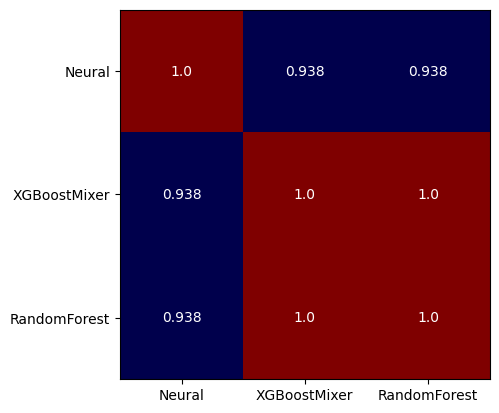

In [10]:
import matplotlib.pyplot as plt
import numpy as np

mc = predictor.runtime_analyzer['mixer_correlation']  # newly produced insight

mixer_names = [c.__class__.__name__ for c in predictor.ensemble.mixers]

# plotting code
fig, ax = plt.subplots()
im = ax.imshow(mc, cmap='seismic')

# set ticks
ax.set_xticks(np.arange(mc.shape[0]))
ax.set_yticks(np.arange(mc.shape[1]))

# set tick labels
ax.set_xticklabels(mixer_names)
ax.set_yticklabels(mixer_names)

# show cell values
for i in range(len(mixer_names)):
    for j in range(len(mixer_names)):
        text = ax.text(j, i, round(mc[i, j], 3), ha="center", va="center", color="w")


Nice! We've just added an additional piece of insight regarding the predictor that Lightwood came up with for the task of predicting the Human Development Index of any given country.

What this matrix is telling us is whether predictions of each pair of the mixers stored in the ensemble have a high correlation or not.

This is, of course, a very simple example, but it shows the convenience of such an abstraction within the broader pipeline that Lightwood automates.

For more complex examples, you can check out any of the three core analysis blocks that we use:

* `lightwood.analysis.nc.calibrate.ICP`
* `lightwood.analysis.helpers.acc_stats.AccStats`
* `lightwood.analysis.helpers.feature_importance.PermutationFeatureImportance`
